In [75]:
#import sys
#!"{sys.executable}" -m pip install numpy
#!"{sys.executable}" -m pip install matplotlib
#!"{sys.executable}" -m pip install pandas

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from alive_progress import alive_bar
from functools import reduce
from math import sqrt
from typing import Collection, Any
results = pd.read_csv("../tests/examples/compilation.csv", delimiter=";")

/tmp/ipykernel_20777/403263405.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv("../tests/examples/compilation.csv", delimiter=";")


# Auxiliary methods

**Method to get a graph from the compilation of data**

The following method receives the name of a column we want to display and compiles a pictrue where the models are sorted by this column and displayed.

The key for the use of this method is to properly apply filters to the data to obtain those rows that are desired.

In [77]:
def sorted_modelsVScolumn(data: pd.core.frame.DataFrame, 
                          column: str, ascending: bool = True, 
                          legend: str = None,
                          xlabel: str = None, ylabel: str = None,
                          file_name:str = "image", 
                          fsize = 20
):
    ## Reading and filtering the data
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sorted_data = data.sort_values(column, ascending = ascending)
    
    xs = range(1,len(data)+1)
    ys = [row[column] for (i, row) in sorted_data.iterrows()]
    
    ## Plotting the data
    legend = column if legend is None else legend
    ax.plot(xs,ys,label=legend,marker='o',linestyle='dashed',color='blue',linewidth=1,markersize=2)
    
    ## Setting some font sizes
    ax.axes.title.set_size(fsize)
    ax.axes.legend(fontsize=fsize-3)
    
    ## Setting axes labels
    xlabel = file_name if xlabel is None else xlabel
    ylabel = column if ylabel is None else ylabel
    ax.set_ylabel(ylabel,fontsize=fsize-7)
    ax.set_xlabel(xlabel,fontsize=fsize-6)
    
    ## Setting tick lables
    #plt.rc('xtick', labelsize=fsize-7)    # fontsize of the tick labels
    #plt.rc('ytick', labelsize=fsize-6)    # fontsize of the tick labels
    plt.xticks(rotation=45)

    ## Setting location of legend
    plt.legend(loc="lower right",fontsize=fsize-4)

    ## Saving file
    fig.fontsize=fsize
    fig.set_size_inches(8.5, 4)
    fig.savefig('figures/'+file_name+'.pdf',bbox_inches='tight')
    


**Method to collect average among the same model**

For the models we may run the lumping algorithm for the same model but different observables sets. This method will compute the average and standard deviation of a column of the data for all the models grouping them by the name of the example (given in the first column). If thi sis applied after some filters, it may help to provide useful information.

In [78]:
def collect_avg_data(dataframe: pd.core.frame.DataFrame, column: str | int, ascending: bool = True, filters : list[tuple[str|int,str,str]]=[]) -> pd.core.frame.DataFrame:
    
    if len(filters) > 0: # we apply the filters first
        valid_names = []
        names_col = dataframe.columns[0]
        names = list(set(dataframe.iloc[:,0].to_list()))
        with alive_bar(len(names), force_tty=True, title="Processing filters with names...") as bar:
            for name in names:
                data_w_name = results.loc[results[names_col]==name]
                for (col, t, val) in filters:
                    col = dataframe.columns.to_list().index(col) if isinstance(col, str) else col
                    to_check = all if t == "all" else any
                    if not to_check(el == val for el in data_w_name.iloc[:,col].to_list()):
                        break
                else:
                    valid_names.append(name)
                bar()
        dataframe = dataframe[dataframe[names_col].isin(valid_names)] # filtered data using the filters
    
    data = dict()
    column = dataframe.columns.to_list().index(column) if isinstance(column, str) else column
    for row in dataframe.itertuples(index=False, name=None):
        if not row[0] in data:
            data[row[0]] = []
        data[row[0]].append(row[column])
             
    for model, stats in data.items():
        avg = np.average(stats)
        std = np.std(stats)
        data[model] = (avg, std, len(stats))
        
    result = [(model, *info) for model, info in data.items()]
    result.sort(key=lambda p : p[1])
    return pd.core.frame.DataFrame(result, columns = ["name", f"avg. {dataframe.columns[column]}", "std", "quantity"])



def avg_w_deviation(data: pd.core.frame.DataFrame, 
                          legend: str = None,
                          xlabel: str = ..., ylabel: str = ...,
                          file_name:str = "image", 
                          fsize = 20
):
    ## Reading and filtering the data
    fig, ax = plt.subplots(nrows=1, ncols=1)
    data = data.sort_values(data.columns[1], ascending = True)
        
    xs = range(1,len(data)+1)
    avg_sem = [row[1]-(row[2]/sqrt(row[3])) for (i, row) in data.iterrows()]
    avg = [row[1] for (i, row) in data.iterrows()]
    avg_plus_sem = [row[1]+(row[2]/sqrt(row[3])) for (i,row) in data.iterrows()]
    
    ## Plotting the data
    legend = data.columns[1] if legend is None else legend
    ax.plot(xs,avg_sem,label=legend + " - SEM", marker='o',linestyle='dashed',color='orange',linewidth=0.5,markersize=1)
    ax.plot(xs,avg_plus_sem,label=legend + " + SEM", marker='*',linestyle='dashed',color='red',linewidth=0.5,markersize=1)
    ax.plot(xs,avg,label=legend,marker='o',linestyle='dashed',color='blue',linewidth=1,markersize=2)
    
    ## Setting some font sizes
    ax.axes.title.set_size(fsize)
    ax.axes.legend(fontsize=fsize-3)
    
    ## Setting axes labels
    xlabel = file_name if xlabel is ... else xlabel
    ylabel = data.columns[1] if ylabel is ... else ylabel
    ax.set_ylabel(ylabel,fontsize=fsize-7)
    ax.set_xlabel(xlabel,fontsize=fsize-6)
    
    ## Setting tick lables
    #plt.rc('xtick', labelsize=fsize-7)    # fontsize of the tick labels
    #plt.rc('ytick', labelsize=fsize-6)    # fontsize of the tick labels
    plt.xticks(rotation=45)

    ## Setting location of legend
    plt.legend(loc="lower right",fontsize=fsize-7)

    ## Saving file
    fig.fontsize=fsize
    fig.set_size_inches(8.5, 4)
    fig.savefig('figures/'+file_name+'.pdf',bbox_inches='tight')

**Method to compute statistics**

In a meeting with Mirco, some statistics were required to display on the paper. These statistics were:
* Total number of examples considered (both by moel name and in general).
* Number of cases there is no actual reduction (i.e., the column "Reducing" is `False`)
* Number of cases where the lumping obtained is not an RWE (i.e., either "Disjoint" or "Positive" is `False`)
* Numebr of positive cases: we got a reduction that is a RWE (i.e., "Disjoint" and "Positive" and "Reducing are `False`).

The following method computes this from a data set:

In [113]:
def get_statistics(dataframe: pd.core.frame.DataFrame):
    total_models = set()
    total_cases = []
    no_reduction = []
    trivial_reduction = []
    not_rwe = []
    rwe = []
    weird = []
    c_red = dataframe.columns.to_list().index("Reducing")
    c_pos = dataframe.columns.to_list().index("Positive")
    c_dis = dataframe.columns.to_list().index("Disjoint")
    c_rat = dataframe.columns.to_list().index("Red. ratio")
    for row in dataframe.itertuples(index=False, name=None):
        total_models.add(row[0])
        case = (row[0], row[-1])
        total_cases.append(case)
        if row[c_rat] == 1:
            no_reduction.append(case)
        elif row[c_red] == "No":
            trivial_reduction.append(case)
        elif (row[c_pos] == "No") or (row[c_dis] == "No"):
            not_rwe.append(case)
        elif (row[c_red] == "Yes" and row[c_pos] == "Yes" and row[c_dis] == "Yes"):
            rwe.append(case)
        else:
            weird.append(case)
    return pd.core.frame.DataFrame(
        [[len(total_models), len(total_cases), len(rwe), len(not_rwe), len(trivial_reduction), len(no_reduction), len(weird)],
        [None,None,
         len(rwe)/len(total_cases)*100, 
         len(not_rwe)/len(total_cases)*100, 
         len(trivial_reduction)/len(total_cases)*100, 
         len(no_reduction)/len(total_cases)*100, 
         len(weird)/len(total_cases)*100
        ]], 
        columns = ["# models", "# cases", "# rwe", "# gen lumping", "# triv. reduction", "# no reduction", "# timeout"]
    )

In [114]:
get_statistics(results)

,# models,# cases,# rwe,# gen lumping,# triv. reduction,# no reduction,# timeout
0,1352.0,110808.0,14742.000000,39318.000000,52629.000000,2495.000000,1624.000000
1,NaN,NaN,13.304094,35.482998,47.495668,2.251642,1.465598


In [99]:
results[(results.Positive != "No") & (results.Disjoint != "No")]

,Name,Read Alg.,Time reading,Matrix Alg.,Time w/ matrices,Or. size,Lmp. size,Red. ratio,Time (s),Unweighted,Positive,Disjoint,Reducing,Weighted model?,Is FL?,Is FE?,Is RWE?,Has RWE?,Observables
2,BIOMD0000000504,polynomial,0.253667,polynomial,0.011055,205,113,0.551220,0.7297351360321045,Yes,Yes,Yes,No,Not computed,Yes,No,Yes,Yes,"['cFos_P', 'cJun_P']"
3,BIOMD0000000504,polynomial,0.253667,polynomial,0.011055,205,133,0.648780,0.887981653213501,Yes,Yes,Yes,No,Not computed,Yes,No,Yes,Yes,"['MMP1_mRNA', 'MMP13_mRNA', 'TIMP1_mRNA']"
4,BIOMD0000000504,polynomial,0.253667,polynomial,0.011055,205,204,0.995122,1.9740779399871826,Yes,Yes,Yes,No,Not computed,Yes,No,Yes,Yes,"['MMP1', 'MMP13', 'ColFrag']"
5,BIOMD0000000504,polynomial,0.253667,polynomial,0.011055,205,113,0.551220,0.7207317352294922,Yes,Yes,Yes,No,Not computed,Yes,No,Yes,Yes,"['JAK1_P', 'JNK_P', 'cJun_P', 'cJun_dimer', 'S..."
6,fceri_ji,polynomial,2.401822,polynomial,0.451352,374,8,0.021390,0.8172662258148193,Yes,Yes,Yes,Yes,Not computed,Yes,No,Yes,Yes,['S0']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110803,eu_procurements_alt_DE_2015[uncertain],uncertain,54.750148,polynomial,0.000007,22324,1,0.000045,0.046584,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,['9948_i']
110804,eu_procurements_alt_IT_2011[uncertain],uncertain,inf,polynomial,inf,oo,oo,NaN,inf,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Unknown
110805,eu_procurements_alt_SE_2010[uncertain],uncertain,inf,polynomial,inf,oo,oo,NaN,inf,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Unknown
110806,eu_procurements_alt_CZ_2009[uncertain],uncertain,inf,polynomial,inf,oo,oo,NaN,inf,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Not computed,Unknown


# Getting images

## 1. RWE reductions with First observable

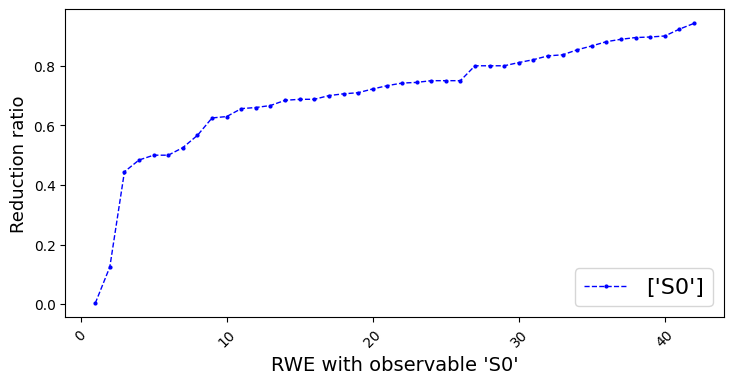

In [81]:
# Filtering the data
conditions_with_observable = [
    results["Read Alg."] == "uncertain",
    results["Unweighted"] == "No",
    results["Positive"] == "Yes",
    results["Disjoint"] == "Yes",
    results["Reducing"] == "Yes",
    results["Observables"] == "['S0']"
]
examples = results[reduce(lambda p, q: p & q, conditions_with_observable)]
sorted_modelsVScolumn(examples, "Red. ratio", legend="['S0']", xlabel="RWE with observable 'S0'", ylabel="Reduction ratio", file_name = "RWE_w_S0")

## 2. RWE reductions with one observable

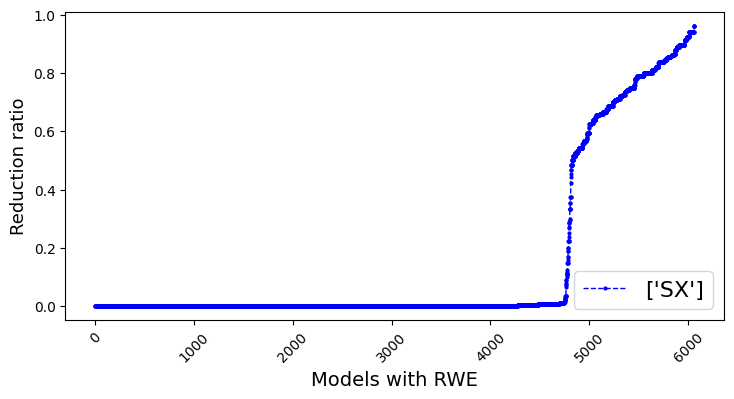

In [82]:
# Filtering the data
conditions_with_observable = [
    results["Read Alg."] == "uncertain",
    results["Unweighted"] == "No",
    results["Positive"] == "Yes",
    results["Disjoint"] == "Yes",
    results["Reducing"] == "Yes"
]
examples = results[reduce(lambda p, q: p & q, conditions_with_observable)]
sorted_modelsVScolumn(examples, "Red. ratio", legend="['SX']", xlabel="Models with RWE", ylabel="Reduction ratio", file_name = "RWE_w_SX")

## 3. RWE and FL reductions with some observable

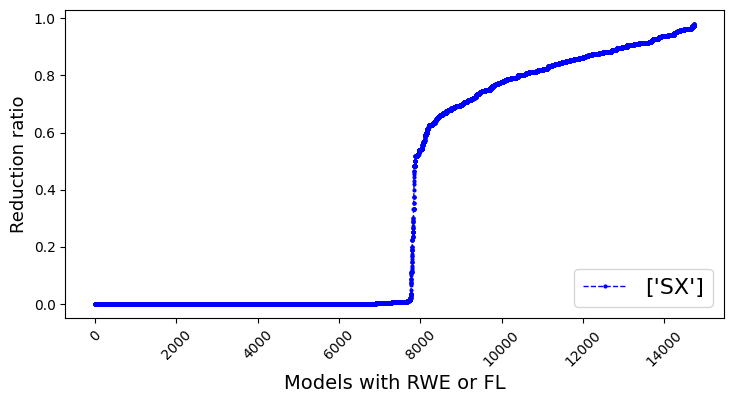

In [83]:
# Filtering the data
conditions_with_observable = [
    results["Read Alg."] == "uncertain",
    results["Positive"] == "Yes",
    results["Disjoint"] == "Yes",
    results["Reducing"] == "Yes",
]
examples = results[reduce(lambda p, q: p & q, conditions_with_observable)]
sorted_modelsVScolumn(examples, "Red. ratio", legend="['SX']", xlabel="Models with RWE or FL", ylabel="Reduction ratio", file_name = "RWE&FL_w_S0")

## 4. Average reduction for models

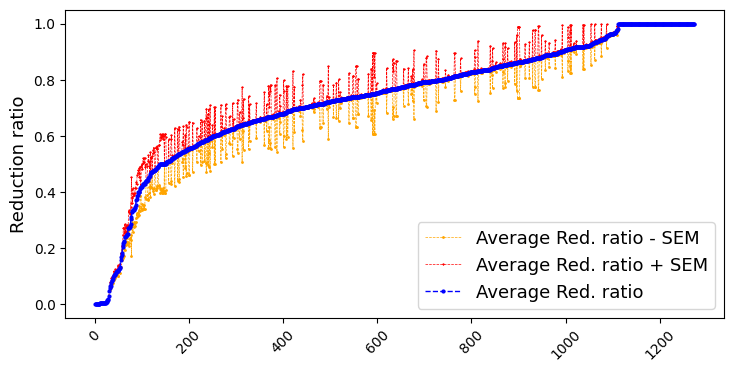

In [103]:
avg_data = collect_avg_data(results, "Red. ratio")
avg_w_deviation(avg_data, legend="Average Red. ratio", xlabel=None, ylabel="Reduction ratio", file_name="average")

We usually only consider examples were *some* reduction happens. So we need to filter when *any* of the cases for a model has "Reducing" as "Yes":

Processing filters with names... |████████████████████████████████████████| 954/954 [100%] in 16.5s (57.84/s)           


547

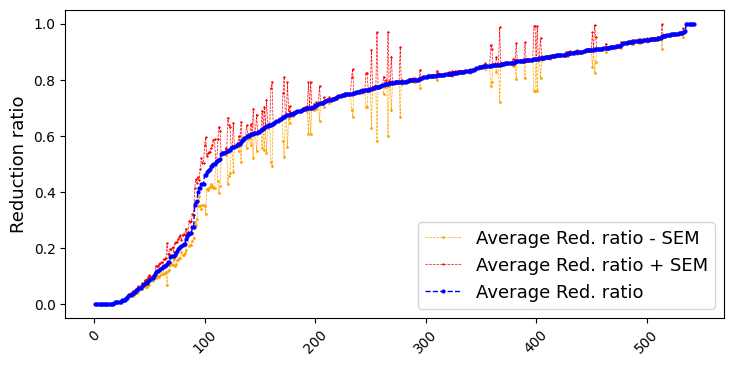

In [101]:
avg_data = collect_avg_data(results[(results["Positive"] != "No") & (results["Disjoint"] != "No")], "Red. ratio", filters=[("Reducing", "any", "Yes")])
avg_w_deviation(avg_data, legend="Average Red. ratio", xlabel=None, ylabel="Reduction ratio", file_name="average_any_red")
len(avg_data)

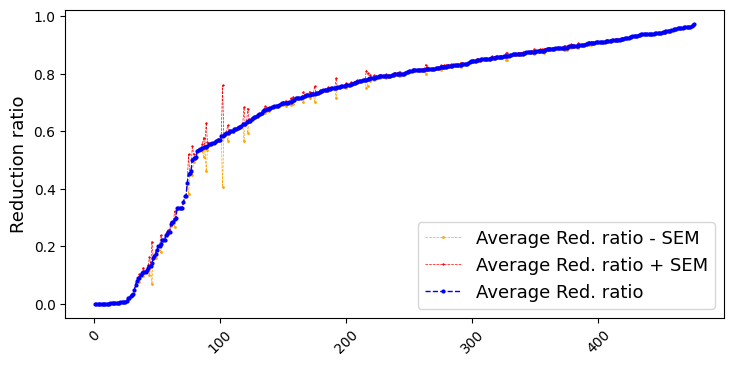

In [102]:
avg_data = collect_avg_data(results[(results["Reducing"]=="Yes") & (results["Positive"] != "No") & (results["Disjoint"] != "No")], "Red. ratio")
avg_w_deviation(avg_data, legend="Average Red. ratio", xlabel=None, ylabel="Reduction ratio", file_name="average_only_red")

# Code from Andrea

In [88]:
add_info_text=False

def make_plot_grouped(names_to_csv_files,step=0.2,dropUnred=False,modelsToConsider=[]):
    fsize=20
    
    xi=0
    for outer_key in names_to_csv_files:
        #print(outer_key)
        grouped_files=names_to_csv_files[outer_key]
        #names_to_loaded_csv_files={ outer_key+"_"+key: pd.read_csv(grouped_files[key],index_col='ModelName') for key in grouped_files}
        names_to_loaded_csv_files={                key: pd.read_csv(grouped_files[key],index_col='ModelName') for key in grouped_files}
        
        if len(modelsToConsider)>0:
            #df2[df2.index.isin(df_red.index)]
            names_to_loaded_csv_files={            key: names_to_loaded_csv_files[key][names_to_loaded_csv_files[key].index.isin(modelsToConsider)] for key in names_to_loaded_csv_files}
        
        if dropUnred:
            names_to_loaded_csv_files={            key: names_to_loaded_csv_files[key][names_to_loaded_csv_files[key][' RedSp/OrigSp']<100.00] for key in names_to_loaded_csv_files}
        
            
        
        
        #print(names_to_loaded_csv_files)
        #failed={ key: names_to_loaded_csv_files[key][' ReductionSucceeded'][names_to_loaded_csv_files[key][' ReductionSucceeded']==0].count() for key in names_to_loaded_csv_files}
        #failed = {k : failed[k] for k in failed if failed[k]>0 }
        #print('Failed:')
        #print(failed)
                
        runtimes={ key: names_to_loaded_csv_files[key][names_to_loaded_csv_files[key][' ReductionSucceeded']==1][' Time(ms)'] for key in names_to_loaded_csv_files}
        print('Reduction runtimes')
        for k in runtimes:
            #print(k,runtimes[k][' Time(ms)'])
            #print(k,type(runtimes[k]))
            print(k,runtimes[k].max())
        print('done\n')
            
        ratios={ key: names_to_loaded_csv_files[key][names_to_loaded_csv_files[key][' ReductionSucceeded']==1][' RedSp/OrigSp']/100.0 for key in names_to_loaded_csv_files}
        #ratios={ key: names_to_loaded_csv_files[key][' RedSp/OrigSp']/100.0 for key in names_to_loaded_csv_files}
        
        #trivial={ key: names_to_loaded_csv_files[key][' ReducedSpecies'][names_to_loaded_csv_files[key][' ReducedSpecies']==1].count() for key in names_to_loaded_csv_files}
        #trivial = {k : trivial[k] for k in trivial if trivial[k]>0 }
        #no_red={ key: names_to_loaded_csv_files[key][' RedSp/OrigSp'][names_to_loaded_csv_files[key][' RedSp/OrigSp']>=99].count() for key in names_to_loaded_csv_files}
        #no_red = {k : no_red[k] for k in no_red if no_red[k]>0 }
        #print(no_red)
        # #print(trivial)
        # print(ratios['AND'],"\n")
        # print(ratios['OR'],"\n")
        x=[ratios[key] for key in ratios]
        n_models=max([len(ratios[key]) for key in ratios])
       
        fig, axes = plt.subplots(nrows=1, ncols=1)
        # plt.rcParams.update({
        #     "text.usetex": True #,"font.family": "sans-serif","font.sans-serif": "Helvetica",
        # })
        ax=axes
        labels=[key for key in ratios]
        #print(labels)
        ax.grid(axis='y')
        x2_0=np.sort(x[0])
        print(x2_0)
        #x2_0=x[0]
        ax.plot(range(1,len(x[0])+1),x2_0,label=labels[0],marker='o',linestyle='dashed',color='blue',linewidth=1,markersize=5)
        ax.grid(axis='y')        
        x2_1=np.sort(x[1])
        print(x2_1)        
        #x2_1=x[1]        
        ax.plot(range(1,len(x[0])+1),x2_1,label=labels[1],marker='o',linestyle='dashed',color='red',linewidth=1,markersize=5)#,alpha=.5
        ax.grid(axis='y')
        #ax.plot(range(len(x[1])),np.sort(x[1]))
        #sns.kdeplot(df['total_bill'], ax=ax2)
       
        # for key in ratios:
        #     ax.plot(x[key])
    
        #step=0.2#0.1#0.05
#         my_bins=np.arange(0,1.01,step)#np.arange(0,1.01,0.05)
#         #my_bins=[0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#         #my_bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#         hist, bins, im = ax.hist(x, bins=my_bins,histtype='bar'
#                             #, color=colors, 
#                             ,label=[key for key in ratios])
#         #print(bins)
#         print(hist)
#         if add_info_text:
#             #plt.text(0.0,n_models,str([histi[0] for histi in hist]),fontsize=15,color="red")
#             plt.text(0.0,n_models+0.05,"Trivial reduct: "+str(trivial)+"\n"+"No reduction: "+str(no_red)+"\nFailed:"+str(failed)+"\n",fontsize=15,color="red")
#             #plt.text(0.0,n_models+0.5,"No reduction: "+str(no_red),fontsize=15,color="red")
        #step=0.2#0.1
        my_yticks=np.arange(0,1.01,step)
        plt.yticks(my_yticks)
        my_xticks=np.arange(1,n_models+1,1)
        plt.xticks(my_xticks)      
        plt.xlim((0.8, n_models+0.2))
        ##plt.yticks([int(y) for y in ax.get_yticks()])
        ##plt.yticks(np.arange(0,n_models+1,1))
        ##plt.yticks(np.arange(0,n_models+1,2))
        #plt.yticks(np.arange(0,30+1,5))#FOR BNS
        #plt.yticks(np.arange(0,45+1,5))#FOR MNS
        #plt.yticks(np.arange(0,max_y+1,2))#FOR BNS

        ax.axes.title.set_size(fsize)
        ax.axes.legend(fontsize=fsize-3)

        #ax.set_ylabel("Number of models out of "+str(n_models),fontsize=fsize-4)
        ax.set_ylabel("Reduction ratios",fontsize=fsize-4)
        ax.set_xlabel(""+outer_key,fontsize=fsize-4)
        
        #ax2 = ax.twinx()
        #ax2.yaxis.set_ticks(np.arange(0,n_models+1,1))
        
        #plt.grid(False)
        plt.rc('xtick', labelsize=fsize-7)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=fsize-6)    # fontsize of the tick labels
        plt.xticks(rotation=45)
        
        #plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=16)
        plt.legend(loc="lower right",fontsize=fsize-4)

        fig.fontsize=fsize
        fig.set_size_inches(8.5, 4)
        file_name=outer_key.replace(' ','').replace('(','').replace(')','')
        fig.savefig('figures/'+file_name+'.pdf',bbox_inches='tight')

### GinSim+BioModels DB

#### Only outputs: one block

Reduction runtimes
AND 524075
OR 557838
done

Reduction runtimes
MIN 864418
MAX 5126789
done



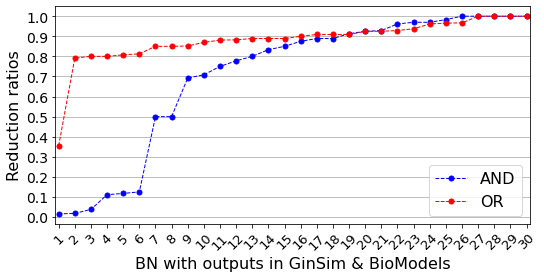

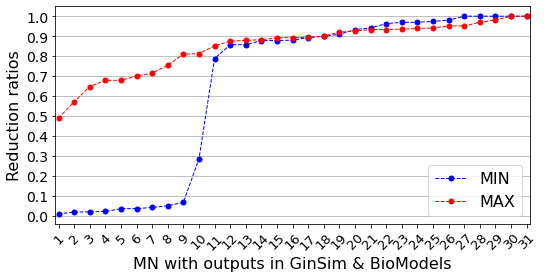

In [16]:
csvFiles={
    "BN with outputs in GinSim & BioModels":
         {
             'AND':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND_clean.csv',
          'OR':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR_clean.csv'
            #'AND':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND.csv',
          #'OR':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
    ,
    "MN with outputs in GinSim & BioModels":
         {'MIN':'ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
          'MAX':'ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
}

make_plot_grouped(csvFiles,step=0.1)

In [104]:
csv_min='ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv'
csv_max='ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv'
df=pd.read_csv(csv_max)
df

,ModelName,Reduction,ReductionSucceeded,Time(ms),InitPartition,Species,ReducedSpecies,RedSp/OrigSp,Reactions,ReducedReactions,Parameters,
0,m2018_zanudo_proliferationzginml,FME,1,4565,2,17,16,94.12,17,16,0,
1,ap_boundaryzginml,FME,1,14279,2,28,25,89.29,28,25,0,
2,Bladder_Modelzginml,FME,1,34552,2,30,28,93.33,30,28,0,
3,BRAF_Modelzginml,FME,1,62842,2,33,32,96.97,33,32,0,
4,Cacace_Tdev_2nov2019zginml,FME,1,125581,2,56,38,67.86,56,38,0,
5,Collombet_model_Bcell_Macrophages_PNAS_170215z...,FME,1,56162,2,33,29,87.88,33,29,0,
6,core_engine_budding_yeast_CCzginml,FME,1,21625,2,27,25,92.59,27,25,0,
7,Dpp__Pathway_11Jun2013zginml,FME,1,3572,2,15,14,93.33,15,14,0,
8,DrosoMesoLogModelzginml,FME,1,102157,2,48,39,81.25,48,39,0,
9,EGF__Pathway_12Jun2013_0zginml,FME,1,16905,2,25,23,92.00,25,23,0,


## Weigthed networks

In [86]:
#df=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER_discrete.csv',index_col='ModelName')
df=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER_discrete_clean.csv',index_col='ModelName')
#df=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER_continuous.csv',index_col='ModelName')
print(len(df))
df_red=df[df[' RedSp/OrigSp']<100.00]
print(len(df_red))
df_red.index.values

72
21


array(['ambassador_1985_1989', 'ambassador_1990_1994', 'ambassador_2002',
       'ambassador_2003', 'ambassador_2004', 'ambassador_2005',
       'ambassador_2006', 'ambassador_2007', 'ambassador_KINSHIP',
       'dom_Hayaki_1989b', 'dom_Sandel_2017a', 'dom_Sandel_2017b',
       'plant_pol_vazquez_All_sites_pooled',
       'plant_pol_vazquez_Arroyo_Goye', 'plant_pol_vazquez_Cerro_Lopez',
       'plant_pol_vazquez_Llao_Llao', 'plant_pol_vazquez_Mascardi__c_',
       'plant_pol_vazquez_Mascardi__nc_',
       'plant_pol_vazquez_Quetrihue__c_',
       'plant_pol_vazquez_Quetrihue__nc_', 'plant_pol_vazquez_Safariland'],
      dtype=object)

615
Reduction runtimes
Discr. time 727604
Cont. time 838971
done

[0.2292 0.25   0.25   0.2569 0.2639 0.2917 0.3056 0.3125 0.3125 0.3194
 0.3264 0.4028 0.5625 0.625  0.7083 0.75   0.7639 0.9091 0.9375 0.9375
 0.9583]
[0.2345 0.2759 0.2759 0.2828 0.2941 0.2941 0.3034 0.3172 0.331  0.3529
 0.3529 0.3931 0.5882 0.6471 0.7083 0.7647 0.7655 0.9091 0.9412 0.9412
 0.9583]


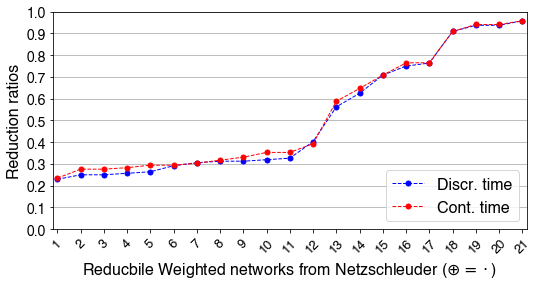

In [89]:
csvFiles={
    "Reducbile Weighted networks from Netzschleuder ($\oplus=\cdot$)":
    #"Reducbile Weighted networks from Netzschleuder":
         {
        'Discr. time':'weightedNetworks/weightedGraphs200/RndTIMES_USER_discrete_clean.csv',
        'Cont. time':'weightedNetworks/weightedGraphs200/RndTIMES_USER_continuous.csv'     
        #'Discr. time':'weightedNetworks/weightedGraphs200/old_RndTIMES_USER200_discr.csv',
        #'Cont. time':'weightedNetworks/weightedGraphs200/old_RndTIMES_USER200_cont.csv'
        #
         # 'Discr. time':'weightedNetworks/weightedGraphs200/RndTIMES_USER200_cont.csv',
         # 'Cont. time':'weightedNetworks/weightedGraphs200/RndTIMES_USER200_cont.csv'
         }
}

#df=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER200_discr.csv',index_col='ModelName')
df=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER_discrete.csv',index_col='ModelName')
print(len(df))
df_red=df[df[' RedSp/OrigSp']<100.00]
models_to_consider=df_red.index.values
make_plot_grouped(csvFiles,step=0.1,dropUnred=False,modelsToConsider=models_to_consider)

In [69]:
models_to_consider

array(['ambassador_1985_1989', 'ambassador_1990_1994', 'ambassador_2002',
       'ambassador_2003', 'ambassador_2004', 'ambassador_2005',
       'ambassador_2006', 'ambassador_2007', 'ambassador_KINSHIP',
       'dom_Anderson_2016d', 'dom_Archie_2006b', 'dom_Archie_2006h',
       'dom_Cafazzo_2010b', 'dom_Collias_1951a', 'dom_Frank_1986a',
       'dom_Funkhouser_2018b', 'dom_Hass_1991b', 'dom_Hass_1991c',
       'dom_Hayaki_1989b', 'dom_Holekamp_1993a', 'dom_Holekamp_1993b',
       'dom_Kohda_1991', 'dom_Murray_2007', 'dom_Patterson_1977',
       'dom_Samuels_1987b', 'dom_Sandel_2017a', 'dom_Sandel_2017b',
       'dom_Seyfarth_1976f', 'dom_Shimoji_2014a', 'dom_Shimoji_2014b',
       'dom_Shimoji_2014c', 'dom_White_2007a', 'dom_White_2007b',
       'dom_White_2007c', 'highschool',
       'plant_pol_vazquez_All_sites_pooled',
       'plant_pol_vazquez_Arroyo_Goye', 'plant_pol_vazquez_Cerro_Lopez',
       'plant_pol_vazquez_Llao_Llao', 'plant_pol_vazquez_Mascardi__c_',
       'plant_pol_v

In [70]:
df_cont=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER200_cont.csv',index_col='ModelName')
df_discr=pd.read_csv('weightedNetworks/weightedGraphs200/RndTIMES_USER200_discr.csv',index_col='ModelName')
#print(len(df_cont[df_cont[' RedSp/OrigSp']<100]))
#print(len(df_discr[df_discr[' RedSp/OrigSp']<100]))
#df_discr[df_discr[' RedSp/OrigSp']<100]
print(len(df_discr))
print(len(df_discr[df_discr[' RedSp/OrigSp']<100]))

1233
44


## Histograms - all aggregation functions in same plot

In [24]:
add_info_text=False

def make_hist_plot_grouped(names_to_csv_files,max_y=30,step=0.2):
    fsize=20
    
    xi=0
    for outer_key in names_to_csv_files:
        #print(outer_key)
        grouped_files=names_to_csv_files[outer_key]
        #names_to_loaded_csv_files={ outer_key+"_"+key: pd.read_csv(grouped_files[key],index_col='ModelName') for key in grouped_files}
        names_to_loaded_csv_files={                key: pd.read_csv(grouped_files[key],index_col='ModelName') for key in grouped_files}
        #print(names_to_loaded_csv_files)
        failed={ key: names_to_loaded_csv_files[key][' ReductionSucceeded'][names_to_loaded_csv_files[key][' ReductionSucceeded']==0].count() for key in names_to_loaded_csv_files}
        failed = {k : failed[k] for k in failed if failed[k]>0 }
        #print('Failed:')
        #print(failed)
                
        ratios={ key: names_to_loaded_csv_files[key][names_to_loaded_csv_files[key][' ReductionSucceeded']==1][' RedSp/OrigSp']/100.0 for key in names_to_loaded_csv_files}
        #ratios={ key: names_to_loaded_csv_files[key][' RedSp/OrigSp']/100.0 for key in names_to_loaded_csv_files}
        
        trivial={ key: names_to_loaded_csv_files[key][' ReducedSpecies'][names_to_loaded_csv_files[key][' ReducedSpecies']==1].count() for key in names_to_loaded_csv_files}
        trivial = {k : trivial[k] for k in trivial if trivial[k]>0 }
        no_red={ key: names_to_loaded_csv_files[key][' RedSp/OrigSp'][names_to_loaded_csv_files[key][' RedSp/OrigSp']>=99].count() for key in names_to_loaded_csv_files}
        no_red = {k : no_red[k] for k in no_red if no_red[k]>0 }
        #print(no_red)
        
        #print(trivial)
        
        #print(ratios)
        x=[ratios[key] for key in ratios]
        n_models=max([len(ratios[key]) for key in ratios])
        #print(x)
        
        fig, axes = plt.subplots(nrows=1, ncols=1)
        ax=axes
        #sns.kdeplot(df['total_bill'], ax=ax2)
        
        #step=0.2#0.1#0.05
        my_bins=np.arange(0,1.01,step)#np.arange(0,1.01,0.05)
        #my_bins=[0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        #my_bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        hist, bins, im = ax.hist(x, bins=my_bins,histtype='bar'
                            #, color=colors, 
                            ,label=[key for key in ratios])
        #print(bins)
        print(hist)
        if add_info_text:
            #plt.text(0.0,n_models,str([histi[0] for histi in hist]),fontsize=15,color="red")
            plt.text(0.0,n_models+0.05,"Trivial reduct: "+str(trivial)+"\n"+"No reduction: "+str(no_red)+"\nFailed:"+str(failed)+"\n",fontsize=15,color="red")
            #plt.text(0.0,n_models+0.5,"No reduction: "+str(no_red),fontsize=15,color="red")
        #step=0.2#0.1
        #my_xticks=np.arange(0,1.01,step)
        my_xticks = bins
        #my_xticks = [0.1, 0.20, 0.3, 0.40, 0.5, 0.60, 0.7,0.80, 0.9]
        plt.xticks(my_xticks)
        ##plt.yticks([int(y) for y in ax.get_yticks()])
        ##plt.yticks(np.arange(0,n_models+1,1))
        ##plt.yticks(np.arange(0,n_models+1,2))
        #plt.yticks(np.arange(0,30+1,5))#FOR BNS
        #plt.yticks(np.arange(0,45+1,5))#FOR MNS
        plt.yticks(np.arange(0,max_y+1,2))#FOR BNS

        ax.axes.title.set_size(fsize)
        ax.axes.legend(fontsize=fsize-4)

        #ax.set_ylabel("Number of models out of "+str(n_models),fontsize=fsize-4)
        ax.set_ylabel("Number of models",fontsize=fsize-4)
        ax.set_xlabel("Reduction ratios for "+outer_key,fontsize=fsize-4)
        
        #ax2 = ax.twinx()
        #ax2.yaxis.set_ticks(np.arange(0,n_models+1,1))
        
        plt.grid(False)
        plt.rc('xtick', labelsize=fsize-5)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=fsize-5)    # fontsize of the tick labels
        
        #plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=16)
        plt.legend(loc="upper center",fontsize=16)

        fig.fontsize=fsize
        fig.set_size_inches(8, 4)
        file_name=outer_key.replace(' ','').replace('(','').replace(')','')
        fig.savefig('figures/'+file_name+'.pdf',bbox_inches='tight')

### GinSim+BioModels DB

#### Only outputs: one block

[[ 3.  3.  0.  0.  0.  2.  1.  3.  6. 13.]
 [ 0.  0.  0.  1.  0.  0.  0.  1. 13. 16.]]


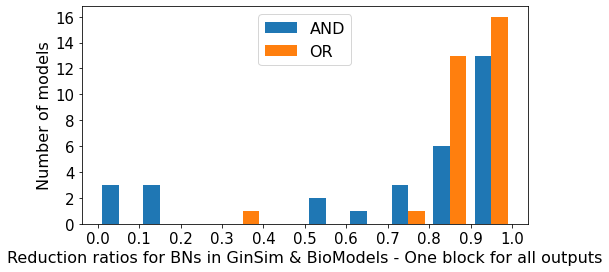

In [25]:
csvFiles={
    "BNs in GinSim & BioModels - One block for all outputs":
         {'AND':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND.csv',
          'OR':'ReductionsBioModelsAndGinSim/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
    ,
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,16,0.1)

[[ 8.  0.  1.  0.  0.  0.  0.  1.  5. 14.]
 [ 0.  0.  0.  0.  1.  1.  3.  2.  9. 13.]]


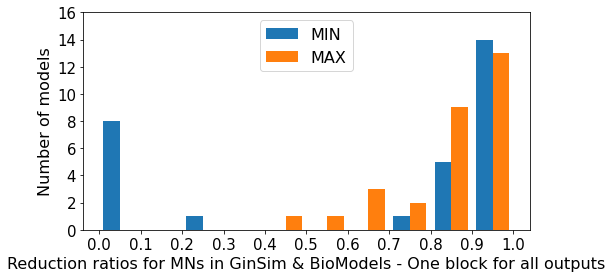

In [16]:
csvFiles={
    "MNs in GinSim & BioModels - One block for all outputs":
         {'MIN':'ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
          'MAX':'ReductionsBioModelsAndGinSim/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
    ,
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,16,0.1)

### BioModels DB

#### Only outputs: one block

[[0. 0. 0. 0. 0. 2. 0. 1. 2. 2.]
 [0. 0. 0. 1. 0. 0. 0. 0. 2. 4.]]


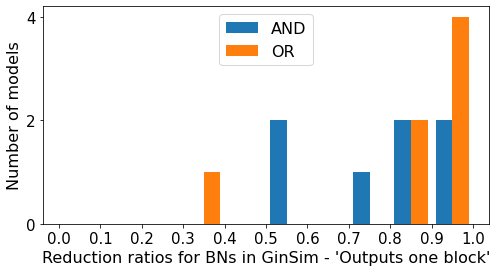

In [20]:
csvFiles={
    "BNs in GinSim - 'Outputs one block'":
         {'AND':'Biomodels_in_SBML_format_ERODE/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND.csv',
          'OR':'Biomodels_in_SBML_format_ERODE/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
    ,
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,4,0.1)


#### Old

[[9. 0. 0. 0. 1.]
 [5. 1. 0. 0. 4.]]
[[0. 0. 2. 0. 5.]
 [0. 1. 0. 0. 6.]]
[[0. 0. 0. 1. 1.]
 [2. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 2.]]


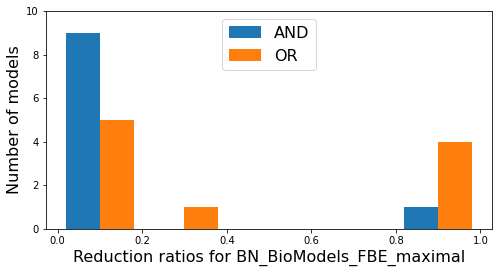

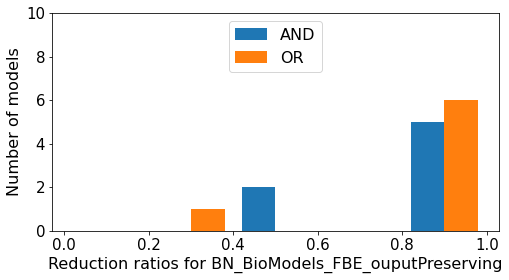

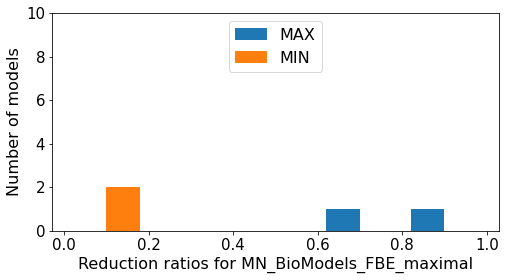

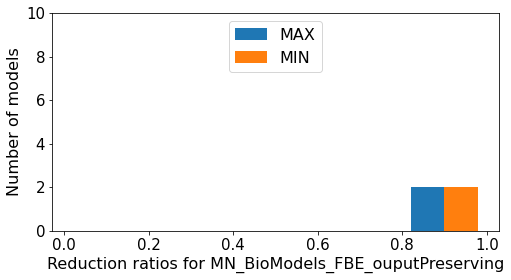

In [3]:
csvFiles={
    'BN_BioModels_FBE_maximal':
         {'AND':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsMaximalFBE_AND.csv',
          #'inputres_FBE_AND':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsInputPreservingFBE_AND.csv',
          #'outputpres_AND':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsOutputPreservingFBE_AND.csv',
          'OR':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsMaximalFBE_OR.csv'#,
          #'inputpres_FBE_OR':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsInputPreservingFBE_OR.csv',
          #'outputpres_OR':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsOutputPreservingFBE_OR.csv'    
         }
    ,
    'BN_BioModels_FBE_ouputPreserving':
         {#'max_AND':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsMaximalFBE_AND.csv',
          #'inputres_FBE_AND':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsInputPreservingFBE_AND.csv',
          'AND':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsOutputPreservingFBE_AND.csv'
          ,
          #'max_OR':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsMaximalFBE_OR.csv',
          #'inputpres_FBE_OR':'Biomodels_in_SBML_format_ERODE/BNs_inputs/reductionsInputPreservingFBE_OR.csv',
          'OR':'Biomodels_in_SBML_format_ERODE/BNs_outputs/reductionsOutputPreservingFBE_OR.csv'    
         }
    ,
    'MN_BioModels_FBE_maximal':
         {#'PLUS':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsMaximalFME_PLUS.csv',
          #'outputpres_PLUS':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_PLUS.csv'   
          #,
          #'TIMES':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsMaximalFME_TIMES.csv',
          #'outputpres_TIMES':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_TIMES.csv'    
          #,
          'MAX':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsMaximalFME_MAX.csv',
          #'outputpres_MAX':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
          #,
          'MIN':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsMaximalFME_MIN.csv'#,
          #'outputpres_MIN':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
         }
    ,
    'MN_BioModels_FBE_ouputPreserving':
         {#'max_PLUS':'Biomodels_in_SBML_format_ERODE/MNs_inputs/reductionsMaximalFME_PLUS.csv',
          #'PLUS':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_PLUS.csv'   
          #,
          #'max_TIMES':'Biomodels_in_SBML_format_ERODE/MNs_inputs/reductionsMaximalFME_TIMES.csv',
          #'TIMES':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_TIMES.csv'    
          #,
          #'max_MAX':'Biomodels_in_SBML_format_ERODE/MNs_inputs/reductionsMaximalFME_MAX.csv',
          'MAX':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
          ,
          #'max_MIN':'Biomodels_in_SBML_format_ERODE/MNs_inputs/reductionsMaximalFME_MIN.csv',
          'MIN':'Biomodels_in_SBML_format_ERODE/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
         }
}
make_hist_plot_grouped(csvFiles,10)

### GinSim

#### Only outputs: one block

[[ 3.  3.  0.  0.  0.  0.  1.  2.  4. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 11. 12.]]


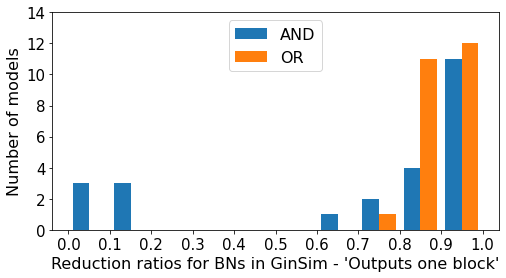

In [21]:
csvFiles={
    "BNs in GinSim - 'Outputs one block'":
         {'AND':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND.csv',
          'OR':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR.csv'
          #,'XOR':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv'
         }
    ,
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,15,0.1)

[[ 0.  0.  0.  0.  1.  1.  3.  2.  9. 13.]
 [ 8.  0.  1.  0.  0.  0.  0.  1.  5. 14.]]


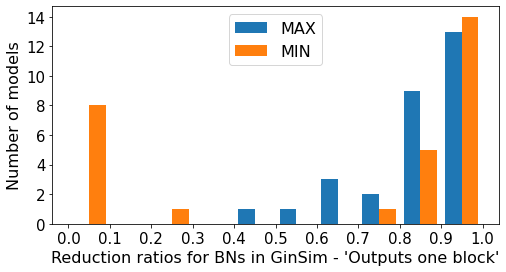

In [22]:
csvFiles={
    "BNs in GinSim - 'Outputs one block'":
         {'MAX':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
          'MIN':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv'
         }
    ,
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,15,0.1)

#### Grouping by technique

[[28.  1.  0.  2.  2.]
 [ 6.  0.  0.  3. 15.]
 [ 0.  0.  0.  1. 23.]]
[[ 3.  0.  0.  1. 29.]
 [ 0.  0.  0.  1. 23.]
 [ 0.  0.  0.  1. 23.]]
[[ 3.  0.  0.  1. 29.]
 [ 0.  0.  0.  0. 24.]
 [ 0.  0.  0.  0. 24.]]
[[ 0.  2.  0.  1. 45.]
 [ 0.  0.  2.  5. 22.]
 [ 0.  0.  0.  1. 28.]]
[[12.  3.  0.  0. 33.]
 [ 8.  1.  0.  1. 19.]
 [ 0.  0.  0.  0. 29.]]


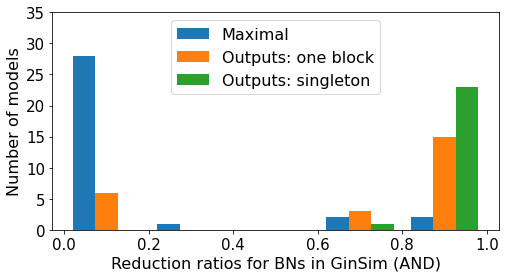

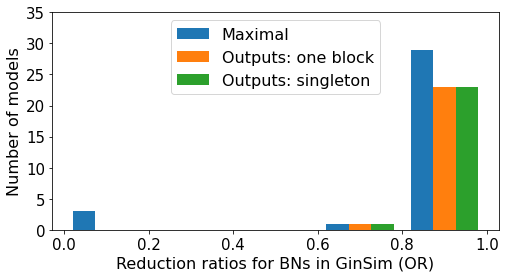

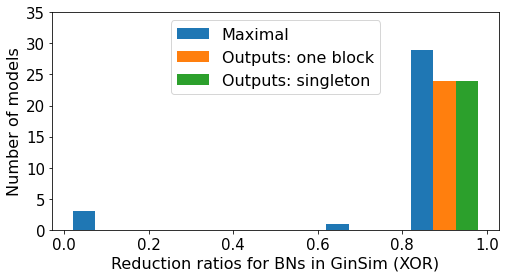

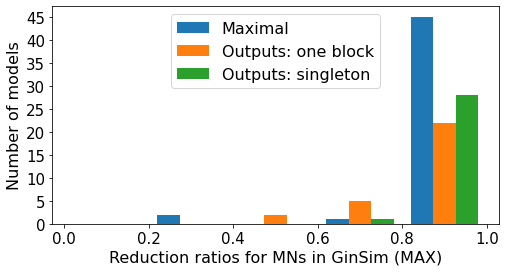

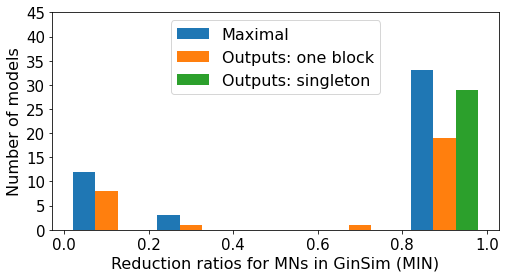

In [25]:
csvFiles={
    'BNs in GinSim (AND)':#'BN_GinSim_FBE_AND':
         {'Maximal':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs/reductionsMaximalFBE_AND.csv',
          'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_AND.csv',
          'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs/reductionsOutputPreservingFBE_AND.csv'
         }
    ,
    'BNs in GinSim (OR)':#'BN_GinSim_FBE_OR':
         {'Maximal':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs/reductionsMaximalFBE_OR.csv',
          'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_OR.csv',
          'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs/reductionsOutputPreservingFBE_OR.csv'
         }
    ,
    'BNs in GinSim (XOR)':#'BN_GinSim_FBE_OR':
         {'Maximal':'GINSIM_SBML_format_ERODE_hpc/BNs_outputs/reductionsMaximalFBE_OR.csv',
          'Outputs: one block':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFBE_XOR.csv',
          'Outputs: singleton':'GINSIM_SBML_format_ERODE_XOR/BNs_outputs/reductionsOutputPreservingFBE_XOR.csv'
         }    
    # ,
    # 'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
    #      }
    # ,
    # 'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
    #      {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
    #       'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
    #       'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
    #      }  
}
make_hist_plot_grouped(csvFiles,35)

csvFiles={
    'MNs in GinSim (MAX)':#'MN_GinSim_FME_MAX':
         {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MAX.csv',
          'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MAX.csv',
          'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MAX.csv'
         }
    ,
    'MNs in GinSim (MIN)':#'MN_GinSim_FME_MIN':
         {'Maximal':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsMaximalFME_MIN.csv',
          'Outputs: one block':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs_oneBlock/reductionsOutputPreservingOneBlockFME_MIN.csv',
          'Outputs: singleton':'GINSIM_SBML_format_ERODE_hpc/MNs_outputs/reductionsOutputPreservingFME_MIN.csv'
         }  
}
make_hist_plot_grouped(csvFiles,45)

#### Grouping by initial partition

## Trash - old stuff

In [9]:
maximal = pd.read_csv('largescale/MaximalReduction.csv',index_col='ID')
#maximal

In [10]:
ID = pd.read_csv('largescale/IDReduction.csv',index_col='ID')
#ID

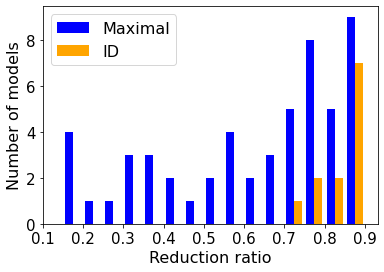

In [11]:
import numpy as np
fsize=20#17
fig, axes = plt.subplots(nrows=1, ncols=1)
ax=axes
x=[maximal['Maximal ratio'].values,ID['ID ratio'].values]
colors = ['blue','orange']

#my_bins=[0, 0.10, 0.20, 0.3, 0.40, 0.5, 0.60, 0.7,0.80, 0.9,1]
first=0.15
#first=0.05
step=0.05
my_bins=[]
#while first <= 1.0:
while first <= 0.95:
    my_bins.append(first)
    first=first+step
#my_bins=np.arange(0,1,0.05)
#print(my_bins)
hist, bins, im = ax.hist(x, bins=my_bins, 
                    histtype='bar', color=colors, 
                    label=['Maximal','ID'])

 # change the x ticks
#my_xticks = bins
my_xticks = [0.1, 0.20, 0.3, 0.40, 0.5, 0.60, 0.7,0.80, 0.9]
plt.xticks(my_xticks)

ax.axes.title.set_size(fsize)
ax.axes.legend(fontsize=fsize-4)

ax.set_ylabel("Number of models",fontsize=fsize-4)
ax.set_xlabel("Reduction ratio",fontsize=fsize-4)
#plt.grid(True)
plt.rc('xtick', labelsize=fsize-4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fsize-4)    # fontsize of the tick labels

fig.fontsize=fsize
fig.savefig('Hist_LargeScale.pdf',bbox_inches='tight')

array([[<AxesSubplot:title={'center':'ID ratio'}>]], dtype=object)

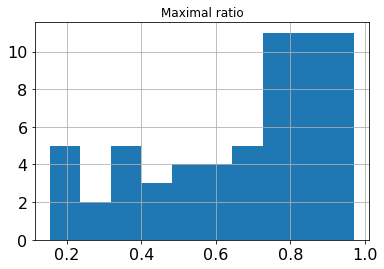

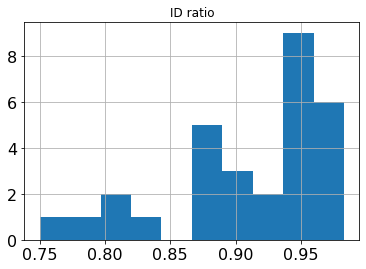

In [12]:
maximal.hist()

ID.hist()

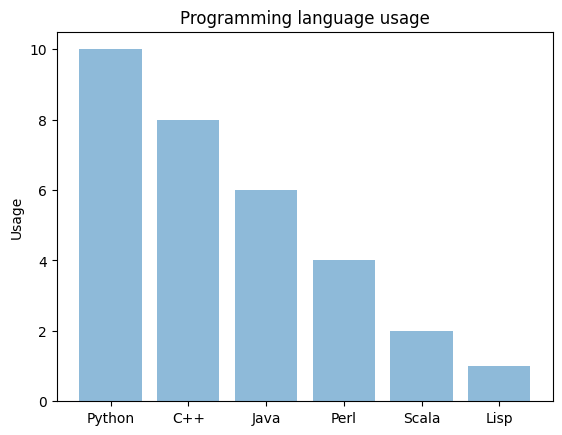

In [13]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

<AxesSubplot:xlabel='ID'>

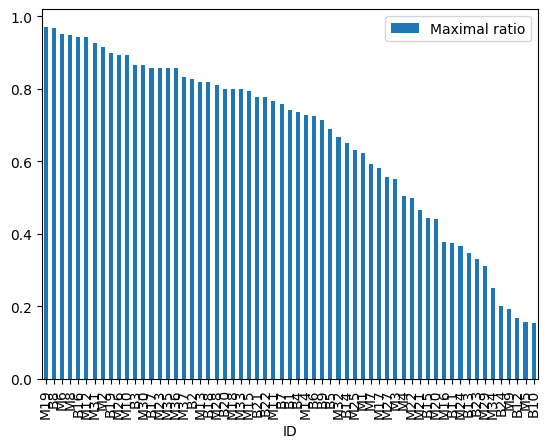

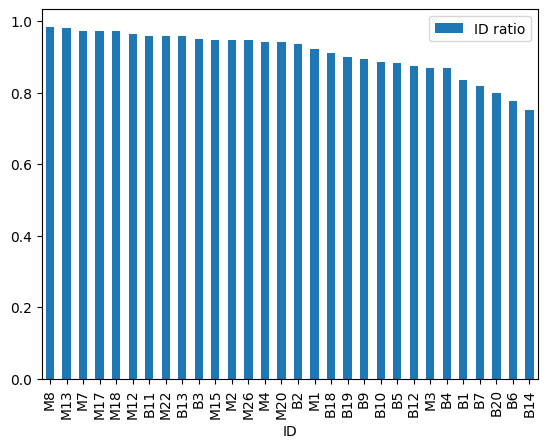

In [14]:
maximal.plot.bar()

ID.plot.bar()

## One figure per case